# Creating and extracting information from saliency maps
* organizing code
* removing multiclass case
* extract quantitative information from the maps

In [2]:
from prep_test_data import *
from pathlib import Path
import json
import torch
from matplotlib import pyplot as plt
import shutil
import numpy as np
import cv2
import csv

-------------------------------------------------------

## Main methods above

In [3]:
def create_maps_folders(main_folder, beat, labels, delete_prior):
    if delete_prior and Path(main_folder).exists():
        shutil.rmtree(main_folder)
    for label in labels:
        folder = Path(main_folder) / f"label_{beat}_beat/"
        Path(folder / label).mkdir(parents=True, exist_ok=True)
    return folder

In [4]:
def deprocess(image):
    transform = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        transforms.ToPILImage(),
    ])
    return transform(image)

def show_img(PIL_IMG):
    plt.imshow(np.asarray(PIL_IMG))

In [228]:
def saliency_maps(model, data, main_folder, n_batches=None):
    classes = data["test"].dataset.classes
    for i, (inputs, labels) in enumerate(data['test']):
        inputs = inputs.to(0)
        labels = labels.to(0)
        x = inputs
        x.requires_grad_();
        scores = model(x)
        score_max_index = scores.argmax(dim=1)

        score_max = scores[:, score_max_index]
        score_max.backward(torch.ones_like(score_max))
        saliency, _ = torch.max(x.grad.data.abs(),dim=1)
        
        print(score_max_index)
        print(labels)
        for index in range(len(saliency)):
            sal = saliency[index].cpu().numpy()
            
            label = classes[labels[index]]
            true = labels[index]
            pred = score_max_index[index]
            pred_res = "OK"
            if pred != true:
                pred_res = "wrong"
            
            plt.figure()
            img1 = plt.imshow(sal, cmap=plt.cm.hot, alpha=.7);
            img2 = plt.imshow(deprocess(x[index].cpu()), alpha=.4);
            plt.axis('off')
            
            input_filename = Path(data['test'].dataset.samples[i*len(saliency)+index][0]).stem
            
            #if input_filename == "0_0_232":
            #    print("entrei")
            #    return sal
                
            plt.savefig(str(main_folder / f"{label}/{input_filename}_{pred_res}.png"))
            plt.close();
                
        if n_batches:
            if i + 1 == n_batches:
                break
        
    return saliency, x

In [229]:
def create_saliency_maps_one_heartbeat(data_path, models_main_path, model_name, beat, saliency_maps_path, nr_egs):
    data_prep = DataPreparation(str(data_path))
    data, size = data_prep.create_dataloaders(16, False, 4)
    model_path = models_main_path / f"label_{beat}/{model_name}.pth"
    model = torch.load(model_path)
    model.eval();
    return saliency_maps(model, data, saliency_maps_path, nr_egs)

----------------------------------------------------------------

## Configuration and run methods!

In [216]:
with open("../config.json") as f:
    config_data = json.load(f)
    f.close()

In [217]:
HEARTBEAT = "final"
MODELS_PATH = Path(f"../models/")
MODEL_NAME = "resnet50_d_22_t_12_17"
MAP_DIR = "../attribution_maps/saliency_maps"
DELETE_PRIOR_DIR = True
TEST_DATA_PATH = Path(f'/mnt/Media/bernardo/DSL_test_data')
NR_BATCHES = 2

tensor([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
entrei


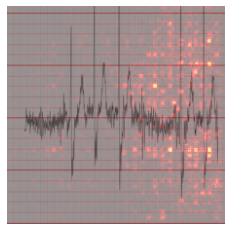

In [224]:
saliency_folder = create_maps_folders(MAP_DIR, HEARTBEAT, config_data['labels_bin'], DELETE_PRIOR_DIR)
saliency, imgs = create_saliency_maps_one_heartbeat(TEST_DATA_PATH, MODELS_PATH, MODEL_NAME, HEARTBEAT, saliency_folder, NR_BATCHES)

In [222]:
saliency.shape

torch.Size([16, 224, 224])

In [28]:
data_prep = DataPreparation(str(TEST_DATA_PATH))
data, size = data_prep.create_dataloaders(16, False, 4)

## Digging into saliency maps and data

## It's important to differentiate the cases where the model gives the correct prediction from those where the prediction is wrong

In [40]:
i = 15
sal = saliency[i].cpu().numpy() # saliency for one sample
img = imgs[i]

In [21]:
sal.shape

(224, 224)

In [22]:
np.max(sal)

1.4449899

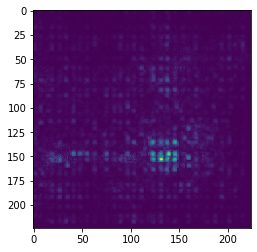

In [23]:
plt.imshow(sal)

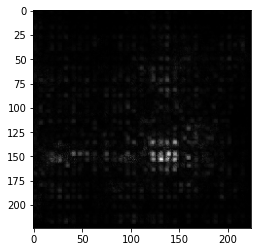

In [33]:
sal_trans = np.uint8(np.interp(sal, (np.min(sal), np.max(sal)), (0,255)))
plt.imshow(cv2.cvtColor(sal_trans, cv2.COLOR_BGR2RGB))

In [28]:
sal_trans = np.uint8(np.interp(sal, (np.min(sal), np.max(sal)), (0,255)))

In [1]:
deprocess(img.cpu()).numpy()

NameError: name 'deprocess' is not defined

# Verify ROIs

In [9]:
TEST_DATA_PATH = Path(f'/mnt/Media/bernardo/DSL_test_data')
roi_file_path = list((Path.cwd().parent / "ROI").glob("*.txt"))[2] # --> label final
roi_file_path

PosixPath('/mnt/Media/bernardo/Documents/PhD/Courses/Deep Structured Learning/code/DSLproject/ROI/5_ROI.txt')

In [31]:
def roi_rectangle(img_path, roi):
    img = cv2.imread(str(img_path))
    top_left = (int(roi[4]), int(roi[3]))
    bottom_right = (int(roi[5]), int(roi[2]))
    print(f"top_left: {top_left}")    
    print(f"bottom_right: {bottom_right}")
    img_rect = cv2.rectangle(img.copy(), top_left, bottom_right, (255,0,0), 2)
    cv2.imshow("roi-test", img)
    cv2.waitKey()
    cv2.destroyAllWindows()
    return top_left, bottom_right, img, img_rect

In [33]:
patient = "232"
file = "0_0"
with open(roi_file_path) as rois:
    rois_reader = csv.reader(rois, delimiter='\t')
    for i, roi in enumerate(rois_reader):
        if roi[0] == patient and roi[1] == file:
            img_path = TEST_DATA_PATH / roi[6] / f"{roi[1]}_{roi[0]}.png"
            left_top, right_bottom, img, img_rect = roi_rectangle(img_path, roi)

top_left: (1948, 137)
bottom_right: (2202, 299)


In [57]:
img_rect.shape

(450, 3000, 3)

In [196]:
crop_x = 750 # each side
crop_y = 125 # each side

In [197]:
y_ratio = 224/200
x_ratio = 224/1500

In [198]:
top_left_cropped_resized = (int((left_top[0]-crop_x)*x_ratio), int((left_top[1]-crop_y)*y_ratio))

In [199]:
delta_x = right_bottom[0] - left_top[0]
delta_y = right_bottom[1] - left_top[1]
delta_x, delta_y

(254, 162)

In [200]:
delta_x_resized = delta_x * x_ratio
delta_y_resized = delta_y * y_ratio
delta_x_resized, delta_y_resized

(37.93066666666667, 181.44000000000003)

In [201]:
img_resized = cv2.resize(img[75:375,750:2250], (224,224))

In [202]:
top_left_cropped_resized

(178, 13)

In [203]:
right_bottom_point = (int(top_left_cropped_resized[0]+delta_x_resized), int(top_left_cropped_resized[1]+delta_y_resized))
right_bottom_point

(215, 194)

In [206]:
test_i = cv2.rectangle(img_resized.copy(), top_left_cropped_resized, right_bottom_point, (0,255,0), 1)

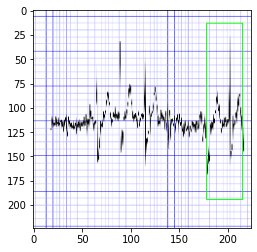

In [207]:
plt.imshow(test_i)

In [130]:
img_rect.shape

(450, 3000, 3)

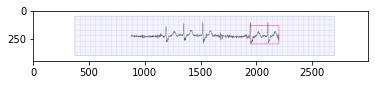

In [121]:
plt.imshow(img_rect)

In [208]:
cv2.imwrite("ROI_final_0_0_232_resized.png", test_i)

True

In [227]:
sal_0_0_232 = saliency

In [234]:
roi_sum = np.sum(sal_0_0_232[top_left_cropped_resized[1]:right_bottom_point[1], top_left_cropped_resized[0]:right_bottom_point[0]])

In [235]:
sal_sum = np.sum(sal_0_0_232)

In [236]:
roi_sum/sal_sum

0.32371974

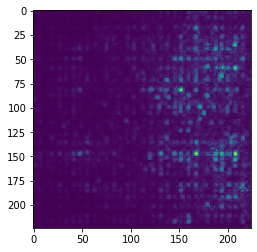

In [237]:
plt.imshow(sal_0_0_232)